# Approximating x^2 with ReLU

## Single layer with no activation - acts like a linear boundary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------
# Data
# -----------------------
torch.manual_seed(0)

N = 2000
x = torch.rand(N, 1) * 4 - 2
y = torch.rand(N, 1) * 4 - 2
X = torch.cat([x, y], dim=1)

labels = (y > x**2).float()

# -----------------------
# Linear -> Linear model
# -----------------------
class LinearStack(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.fc1(x)     # NO activation
        out = self.fc2(h)   # NO activation
        return out

hidden_dim = 100  # change this freely
model = LinearStack(hidden_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# -----------------------
# Training
# -----------------------
for epoch in range(1000):
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


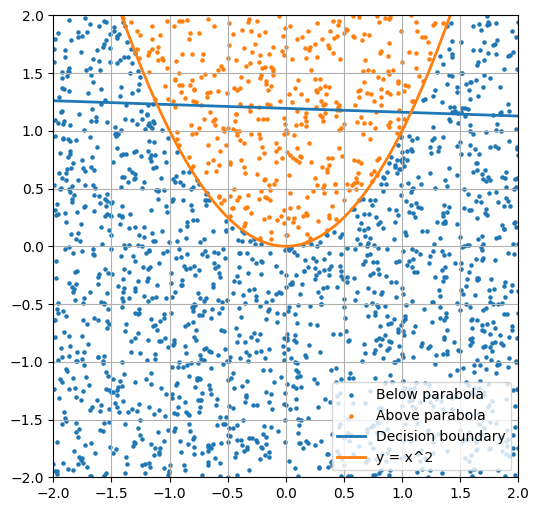

In [2]:
with torch.no_grad():
    # collapse effective linear weights
    W_eff = model.fc2.weight @ model.fc1.weight
    b_eff = model.fc2.weight @ model.fc1.bias + model.fc2.bias

w1, w2 = W_eff[0]
b = b_eff[0]

xx = torch.linspace(-2, 2, 200)
yy = -(w1 * xx + b) / w2

plt.figure(figsize=(6, 6))
plt.scatter(x[labels.squeeze()==0], y[labels.squeeze()==0], s=5, label="Below parabola")
plt.scatter(x[labels.squeeze()==1], y[labels.squeeze()==1], s=5, label="Above parabola")

plt.plot(xx.numpy(), yy.numpy(), linewidth=2, label="Decision boundary")
plt.plot(xx.numpy(), (xx**2).numpy(), linewidth=2, label="y = x^2")

plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()


## Single layer with activation

### Able to bend the lines to fit the parabola within training region but not very precise

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------
# Data
# -----------------------
torch.manual_seed(0)

N = 2000
x = torch.rand(N, 1) * 4 - 2
y = torch.rand(N, 1) * 4 - 2
X = torch.cat([x, y], dim=1)

labels = (y > x**2).float()

# -----------------------
# Linear -> ReLU -> Linear
# -----------------------
class OneHiddenReLU(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = self.relu(self.fc1(x))
        out = self.fc2(h)
        return out

hidden_dim = 4   # <-- CHANGE THIS (1, 2, 5, 10, ...)
model = OneHiddenReLU(hidden_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# -----------------------
# Training
# -----------------------
for epoch in range(2000):
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


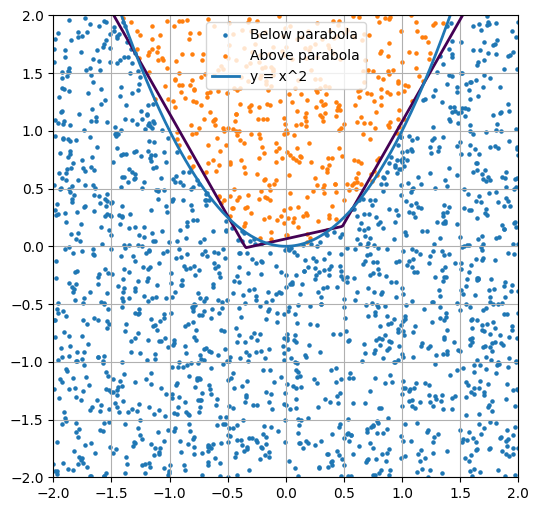

In [4]:
# -----------------------
# Decision boundary
# -----------------------
xx, yy = torch.meshgrid(
    torch.linspace(-2, 2, 300),
    torch.linspace(-2, 2, 300),
    indexing="ij"
)

grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1)

with torch.no_grad():
    logits = model(grid)
    preds = torch.sigmoid(logits).reshape(xx.shape)

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(6, 6))

plt.scatter(x[labels.squeeze()==0], y[labels.squeeze()==0], s=5, label="Below parabola")
plt.scatter(x[labels.squeeze()==1], y[labels.squeeze()==1], s=5, label="Above parabola")

plt.contour(xx.numpy(), yy.numpy(), preds.numpy(), levels=[0.5], linewidths=2)

plt.plot(xx[:,0].numpy(), (xx[:,0]**2).numpy(), linewidth=2, label="y = x^2")

plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()


## 2 layers with activation

### Able to bend the lines to fit the parabola within training region and is more precise

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------
# Data
# -----------------------
torch.manual_seed(0)

N = 2000
x = torch.rand(N, 1) * 4 - 2
y = torch.rand(N, 1) * 4 - 2
X = torch.cat([x, y], dim=1)

labels = (y > x**2).float()


class TwoHiddenReLU(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        h1 = self.relu1(self.fc1(x))
        h2 = self.relu2(self.fc2(h1))
        out = self.fc3(h2)
        return out

hidden_dim1 = 4
hidden_dim2 = 4
model = TwoHiddenReLU(hidden_dim1, hidden_dim2)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# -----------------------
# Training
# -----------------------
for epoch in range(2000):
    optimizer.zero_grad()
    logits = model(X)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


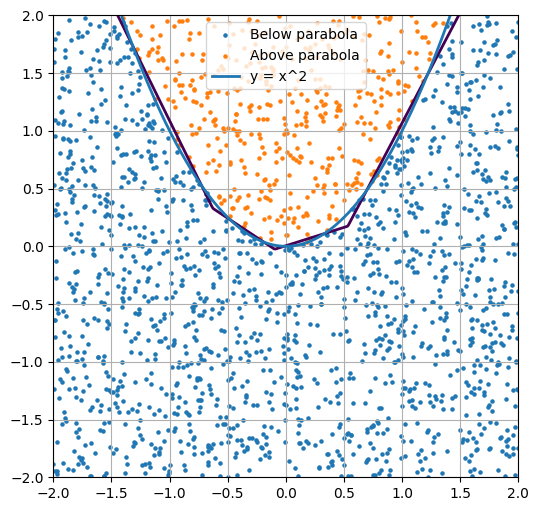

In [6]:
# -----------------------
# Decision boundary
# -----------------------
xx, yy = torch.meshgrid(
    torch.linspace(-2, 2, 300),
    torch.linspace(-2, 2, 300),
    indexing="ij"
)

grid = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)], dim=1)

with torch.no_grad():
    logits = model(grid)
    preds = torch.sigmoid(logits).reshape(xx.shape)

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(6, 6))

plt.scatter(x[labels.squeeze()==0], y[labels.squeeze()==0], s=5, label="Below parabola")
plt.scatter(x[labels.squeeze()==1], y[labels.squeeze()==1], s=5, label="Above parabola")

plt.contour(xx.numpy(), yy.numpy(), preds.numpy(), levels=[0.5], linewidths=2)

plt.plot(xx[:,0].numpy(), (xx[:,0]**2).numpy(), linewidth=2, label="y = x^2")

plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()
